In [1]:
import pandas as pd
from datetime import datetime

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## データ読み込み

In [2]:
# 学習用データと評価用データを読み込む
train_org = pd.read_csv('../data/smfg_train.csv', index_col=0)
test_org = pd.read_csv('../data/smfg_test.csv', index_col=0)

In [3]:
train_org[['created_at', 'health', 'tree_dbh', 'steward', 'spc_common', 'nta_name']].head()

,created_at,health,tree_dbh,steward,spc_common,nta_name
0,2015-06-29,1,14,NaN,English oak,Douglas Manor-Douglaston-Little Neck
1,2016-09-21,1,5,3or4,crimson king maple,Bedford Park-Fordham North
2,2015-09-13,2,26,NaN,English oak,Annadale-Huguenot-Prince's Bay-Eltingville
3,2016-05-09,0,15,NaN,honeylocust,Charleston-Richmond Valley-Tottenville
4,2016-06-24,1,23,NaN,London planetree,Central Harlem North-Polo Grounds


## データセット作成

In [4]:
# train由来は0、test由来は1とする列を追加
train_org['is_test'] = 0
test_org['is_test'] = 1

# ユニオン前にカラムを揃える
# testには目的変数（health）が含まれていないので、ダミー変数を追加
test_org['health'] = -1  # 仮の値を割り当て

# trainとtestをユニオン（結合）
dataset = pd.concat([train_org, test_org], ignore_index=True)
dataset[['created_at', 'health', 'tree_dbh', 'steward', 'spc_common', 'nta_name', 'is_test']].head()

,created_at,health,tree_dbh,steward,spc_common,nta_name,is_test
0,2015-06-29,1,14,NaN,English oak,Douglas Manor-Douglaston-Little Neck,0
1,2016-09-21,1,5,3or4,crimson king maple,Bedford Park-Fordham North,0
2,2015-09-13,2,26,NaN,English oak,Annadale-Huguenot-Prince's Bay-Eltingville,0
3,2016-05-09,0,15,NaN,honeylocust,Charleston-Richmond Valley-Tottenville,0
4,2016-06-24,1,23,NaN,London planetree,Central Harlem North-Polo Grounds,0


## 特徴量エンジニアリング

In [5]:
def create_feature(train_org):
    train = train_org.copy()
    train.fillna('NULL', inplace=True)
    train['bool_problems'] = train['problems'].apply(lambda x: 0 if x=='NULL' else 1)
    
    # created_atをdatetime型に変換
    train['created_at'] = pd.to_datetime(train['created_at'])

    # 季節の特徴量
    # 12~2: 1, 3~5: 2, 6~8: 3, 9~11=4
    train['season'] = train['created_at'].dt.month%12 // 3 + 1
    train[['created_at', 'health', 'season']][10:15]
    
    # 歩道の状態の影響を数値化
    sidewalk_condition = {'NoDamage': 1, 'Damage': 2}
    train['sidewalk_impact'] = train['sidewalk'].map(sidewalk_condition)
    
    # 保護の状態の影響を数値化
    guards_condition = {'Helpful': 3, 'Harmful': 0, 'Unsure': 2, 'NULL': 1}
    train['guards_impact'] = train['guards'].map(guards_condition)

    # 木の管理者の影響を数値化
    steward_condition = {'4orMore': 3, '3or4': 2, '1or2': 1, 'NULL': 0}
    train['num_steward'] = train['steward'].map(steward_condition)
    
    # 木の種類の頻度を計算
    tree_type_freq = train['spc_common'].value_counts().rename('tree_type_freq')
    train['tree_type_freq'] = train['spc_common'].map(tree_type_freq)

    # 地域ごとの木の健康状態の平均を計算し、列名を変更
    nta_health_avg = train.groupby('nta')['health'].mean().rename('nta_health_avg')
    nta_health_avg_df = nta_health_avg.reset_index()
    if 'nta_health_avg' in train.columns:
        train = train.drop(columns=['nta_health_avg'])
    train = train.merge(nta_health_avg_df, on='nta', how='left')

    # 地域ごとの木の種類の多様性
    nta_spc_diversity = train.groupby('nta')['spc_common'].nunique().rename('nta_spc_diversity')
    nta_spc_diversity_df = nta_spc_diversity.reset_index()
    if 'nta_spc_diversity' in train.columns:
        train = train.drop(columns=['nta_spc_diversity'])
    train = train.merge(nta_spc_diversity_df, on='nta', how='left')
    
    # エリア内の平均木直径を計算
    nta_avg_dbh = train.groupby('nta')['tree_dbh'].mean().rename('nta_avg_dbh')
    nta_avg_dbh_df = nta_avg_dbh.reset_index()
    if 'nta_avg_dbh' in train.columns:
        train = train.drop(columns=['nta_avg_dbh'])
    train = train.merge(nta_avg_dbh_df, on='nta', how='left')

    # 木種の人気度を計算
    spc_popularity = train['spc_common'].value_counts().rename('spc_popularity').reset_index()
    spc_popularity = spc_popularity.rename(columns={'index': 'spc_common'})
    if 'spc_popularity' in train.columns:
        train = train.drop(columns=['spc_popularity'])
    train = train.merge(spc_popularity, on='spc_common', how='left')
    
    return train

In [6]:
dataset1 = create_feature(dataset)

In [7]:
dataset1[['sidewalk', 'sidewalk_impact']].head()

,sidewalk,sidewalk_impact
0,Damage,2
1,NoDamage,1
2,NoDamage,1
3,Damage,2
4,NoDamage,1


In [8]:
# train.fillna('NULL', inplace=True)

# train['bool_problems'] = train['problems'].apply(lambda x: 0 if x=='NULL' else 1)

# # created_atをdatetime型に変換
# train['created_at'] = pd.to_datetime(train['created_at'])

# # 季節の特徴量
# # 12~2: 1, 3~5: 2, 6~8: 3, 9~11=4
# train['season'] = train['created_at'].dt.month%12 // 3 + 1
# train[['created_at', 'health', 'season']][10:15]

# # エリア内の平均木直径を計算
# nta_avg_dbh = train.groupby('nta')['tree_dbh'].mean().rename('nta_avg_dbh')
# nta_avg_dbh_df = nta_avg_dbh.reset_index()

# # 木種の人気度を計算
# spc_popularity = train['spc_common'].value_counts().rename('spc_popularity').reset_index()
# spc_popularity = spc_popularity.rename(columns={'index': 'spc_common'})

# # 地域ごとの木の健康状態の平均を計算し、列名を変更
# nta_health_avg = train.groupby('nta')['health'].mean().rename('nta_health_avg')

# # 結合のために、シリーズをDataFrameに変換
# nta_health_avg_df = nta_health_avg.reset_index()
# nta_health_avg_df.head()

# # もし train に nta_health_avg 列が存在する場合は、その列を削除
# if 'nta_health_avg' in train.columns:
#     train = train.drop(columns=['nta_health_avg'])

# # train と nta_health_avg_df を結合
# train = train.merge(nta_health_avg_df, on='nta', how='left')

# train[['created_at', 'health', 'nta', 'nta_health_avg']][10:15]

# 地域ごとの木の種類の多様性
# nta_spc_diversity = train.groupby('nta')['spc_common'].nunique().rename('nta_spc_diversity')
# # 結合のために、シリーズをDataFrameに変換
# nta_spc_diversity_df = nta_spc_diversity.reset_index()
# nta_spc_diversity_df.head()

# もし train に nta_spc_diversity 列が存在する場合は、その列を削除
# if 'nta_spc_diversity' in train.columns:
#     train = train.drop(columns=['nta_spc_diversity'])

# # train と nta_spc_diversity_df を結合
# train = train.merge(nta_spc_diversity_df, on='nta', how='left')

# train[['created_at', 'health', 'nta', 'nta_spc_diversity']][10:15]

In [9]:
(
    dataset1[['created_at', 'created_at', 'health', 
           'tree_dbh', 'steward', 'spc_common', 
           'nta_name', 'bool_problems']]
    .head()
)

,created_at,created_at,health,tree_dbh,steward,spc_common,nta_name,bool_problems
0,2015-06-29,2015-06-29,1,14,NULL,English oak,Douglas Manor-Douglaston-Little Neck,0
1,2016-09-21,2016-09-21,1,5,3or4,crimson king maple,Bedford Park-Fordham North,0
2,2015-09-13,2015-09-13,2,26,NULL,English oak,Annadale-Huguenot-Prince's Bay-Eltingville,1
3,2016-05-09,2016-05-09,0,15,NULL,honeylocust,Charleston-Richmond Valley-Tottenville,0
4,2016-06-24,2016-06-24,1,23,NULL,London planetree,Central Harlem North-Polo Grounds,1


## テストデータの特徴量作成

In [10]:
# test.fillna('NULL', inplace=True)
# test['bool_problems'] = test['problems'].apply(lambda x: 0 if x=='NULL' else 1)

## テストデータ分割

In [11]:
# 'is_test' 列を使って元の train と test データセットに戻す
train = dataset1[dataset1['is_test'] == 0].drop(columns=['is_test'])
test = dataset1[dataset1['is_test'] == 1].drop(columns=['is_test', 'health'])

In [12]:
from sklearn.model_selection import train_test_split
# stratifyを設定することで目的変数の分布を保ったまま分割することができます。
train, valid = train_test_split(train, test_size=0.2, stratify=train['health'], random_state=82)

In [13]:
train.columns

Index(['created_at', 'tree_dbh', 'curb_loc', 'health', 'steward', 'guards',
       'sidewalk', 'user_type', 'problems', 'spc_common', 'spc_latin', 'nta',
       'nta_name', 'borocode', 'boro_ct', 'boroname', 'zip_city', 'cb_num',
       'st_senate', 'st_assem', 'cncldist', 'bool_problems', 'season',
       'sidewalk_impact', 'guards_impact', 'num_steward', 'tree_type_freq',
       'nta_health_avg', 'nta_spc_diversity', 'nta_avg_dbh', 'spc_popularity'],
      dtype='object')

In [14]:
# 使用する特徴量の選択
select_cols = [
    'tree_dbh', 'bool_problems', 'season',
    'sidewalk_impact', 'guards_impact', 'num_steward', 'tree_type_freq',
    'bool_problems', 'tree_type_freq', #'user_type',
    'nta_health_avg', 'nta_spc_diversity', 'nta_avg_dbh', 'spc_popularity'
]

# 目的変数とそれ以外に学習用データを分割
x_train = train[select_cols]
y_train = train['health']
x_valid = valid[select_cols]
y_valid = valid['health']

# カテゴリのままでは学習できないのでワンホットエンコーディングで数値化
x_train = pd.get_dummies(x_train)
x_valid = pd.get_dummies(x_valid)
test =pd.get_dummies(test[select_cols])


In [15]:
x_train.head()

,tree_dbh,bool_problems,season,sidewalk_impact,guards_impact,num_steward,tree_type_freq,bool_problems,tree_type_freq,nta_health_avg,nta_spc_diversity,nta_avg_dbh,spc_popularity
2812,6,1,3,2,1,0,4254,1,4254,0.020067,49,12.879599,4254
10438,19,1,3,2,1,0,50,1,50,0.119048,15,14.928571,50
9859,4,0,4,2,1,0,184,0,184,-0.097872,41,13.557447,184
8505,4,0,3,1,1,0,51,0,51,0.014851,38,10.000000,51
19497,15,0,4,2,1,2,3016,0,3016,-0.052758,62,10.988010,3016


## ランダムフォレスト

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

valid_predictions = model.predict(x_valid)
valid_f1 = f1_score(y_valid, valid_predictions, average='macro')
print(f"Validation F1 Score (Macro): {valid_f1}")


Validation F1 Score (Macro): 0.32479534636573326


In [17]:
pred = model.predict(test)
print(pred[15:30])

[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]


## 特徴量の重要度

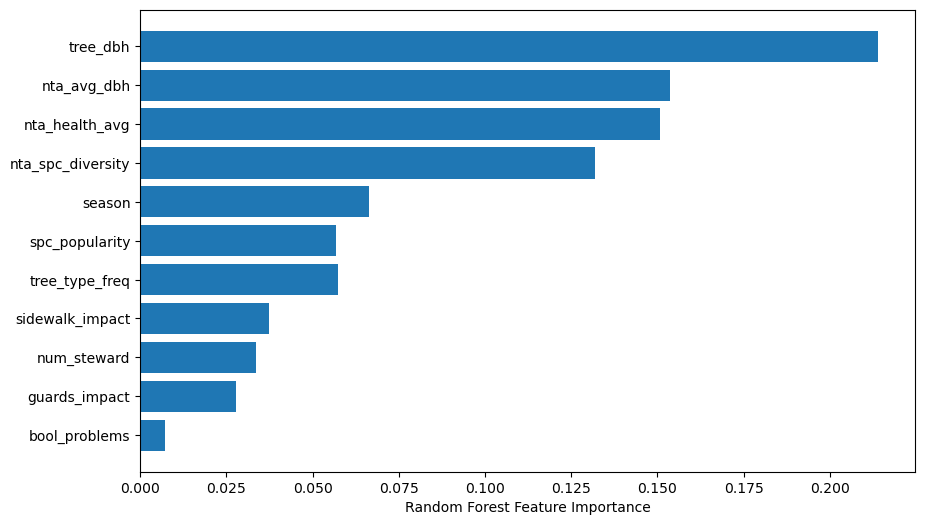

In [18]:
import matplotlib.pyplot as plt

# 特徴量重要度を取得
feature_importances = model.feature_importances_

# 特徴量の名前を取得
feature_names = x_train.columns

# 特徴量の重要度を降順にソート
sorted_idx = feature_importances.argsort()

# 特徴量の重要度をプロット
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

## SHAP

In [19]:
import shap

# SHAP値を計算するためのExplainerを作成
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)

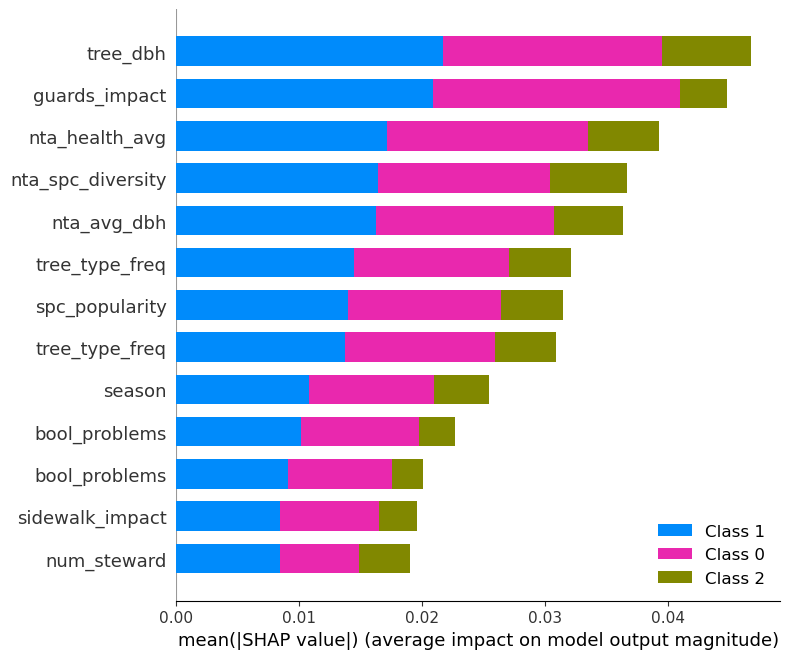

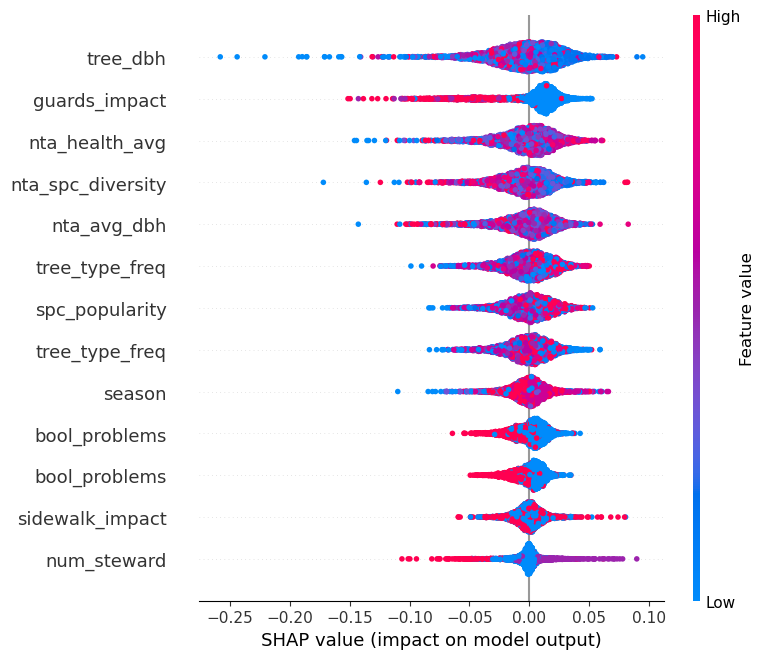

In [20]:
# SHAP値をプロット（最初の10個のデータポイントに対するSHAP値）
shap.summary_plot(shap_values, x_valid, plot_type="bar", show=False)
plt.show()

# 全データに対するSHAP値の要約プロット
shap.summary_plot(shap_values[1], x_valid)


## 提出データ保存

In [21]:
sample_submit = pd.read_csv('../data/sample_submission.csv', index_col=0, header=None) # 応募用サンプルファイル
sample_submit[1] = pred
sample_submit.to_csv('../submit/submit3.csv', header=None)